#### In this notebook, we test extrapolation using the three layers of IFT

In [29]:
import uproot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import awkward as akcv
from tqdm import tqdm
import pandas as pd
import math
from scipy import stats
import os
import random
from numba import jit, njit, vectorize, cuda
from scipy.spatial.distance import cdist

In [30]:
IFT = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit.root")
# IFT['spfit'].show()

### Split layers of IFT

In [31]:
# As awkward arrays
tree = IFT['spfit']
ift = tree.arrays(['sp_track_x',
                   'sp_track_y',
                   'sp_track_z',
                   'sp_track_x_err',
                   'sp_track_y_err',
                   'sp_track_z_err',
                   'sp_track_x_predicted',
                   'sp_track_y_predicted',
                   'sp_track_z_predicted',
                   'sp_track_x_residual',
                   'sp_track_y_residual',
                   'sp_track_z_residual',
                   'track_p1',                  # tx
                   'track_p3'], library='ak')   # ty

def DefineIFT(data, status=''):
    if status =='first': # first layer
        position = ak.where(ak.num(data)==3)
        result = ak.firsts(data[position])  
    elif status == 'second': # second layer
        result = ak.mask(data, ak.num(data)==3)[:, 1]
        result = result[~ak.is_none(result)]
    elif status == 'third': # third layer
        result = ak.mask(data, ak.num(data)==3)[:, -1]
        result = result[~ak.is_none(result)]
    else:
        print('missing element')
    return result

def ConvertPanda(data, status):
    dict = {"x": DefineIFT(ift['sp_track_x'], status=status), "y":DefineIFT(ift['sp_track_y'], status=status), "z":DefineIFT(ift['sp_track_z'], status=status),
            'x error':DefineIFT(ift['sp_track_x_err'], status=status), 'y error':DefineIFT(ift['sp_track_y_err'], status=status), 
            "tx":DefineIFT(ift['track_p1'], status=status), "ty":DefineIFT(ift['track_p3'], status=status)}
    return pd.DataFrame(dict)

ift_first_layer = ConvertPanda(ift, 'first')
ift_second_layer = ConvertPanda(ift, 'second')
ift_third_layer = ConvertPanda(ift, 'third')


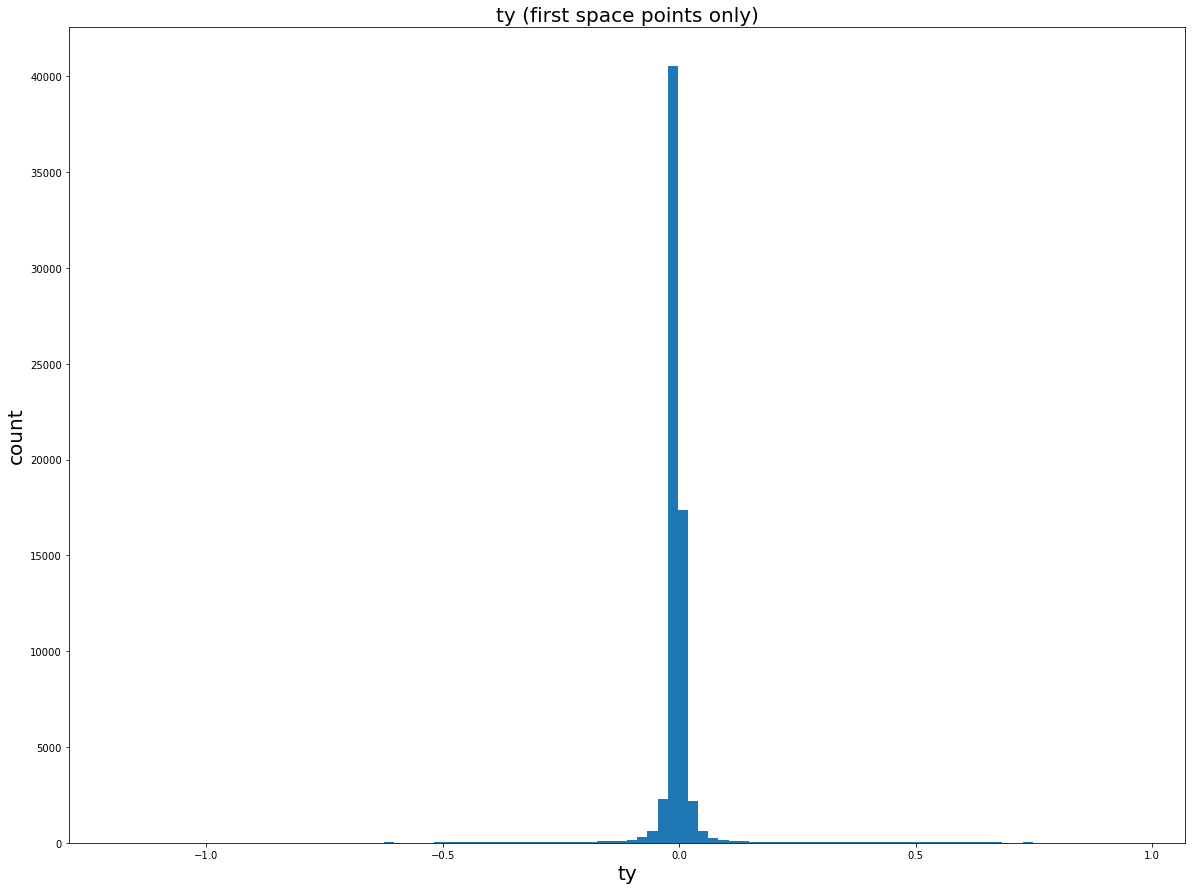

In [40]:
fig = plt.figure(figsize=(20,15))

plt.hist(ift_first_layer['ty'], bins=100)
plt.title("ty (first space points only)", size=20)
plt.xlabel("ty",size=20)
plt.ylabel("count",size=20)
plt.show()

### Applying Cuts on ty

In [41]:
def Filter(data, ty_lower_cut, ty_upper_cut=0, upper=False):
    mean = np.mean(data['ty'])
    filter1 = data[data['ty'] > (mean + ty_lower_cut)]
    filter2 = data[data['ty'] < (mean - ty_lower_cut)]
    filter12 = pd.concat([filter1, filter2])
    filter = filter12
    if upper:
        filter3 = filter[filter['ty'] > (mean - ty_upper_cut)]
        filter4 = filter3[filter3['ty'] < (mean + ty_upper_cut)]
        filter = filter4
    print(f'{len(filter)/len(data)*100}% data is selected after cut')
    return filter

ift_tyCut_L1 = Filter(ift_first_layer, ty_lower_cut=0.6, ty_upper_cut=1.19, upper=True)
ift_tyCut_L2 = Filter(ift_second_layer, ty_lower_cut=0.6, ty_upper_cut=1.19, upper=True)
ift_tyCut_L3 = Filter(ift_third_layer, ty_lower_cut=0.6, ty_upper_cut=1.19, upper=True)

0.3832053467706652% data is selected after cut
0.3832053467706652% data is selected after cut
0.3832053467706652% data is selected after cut


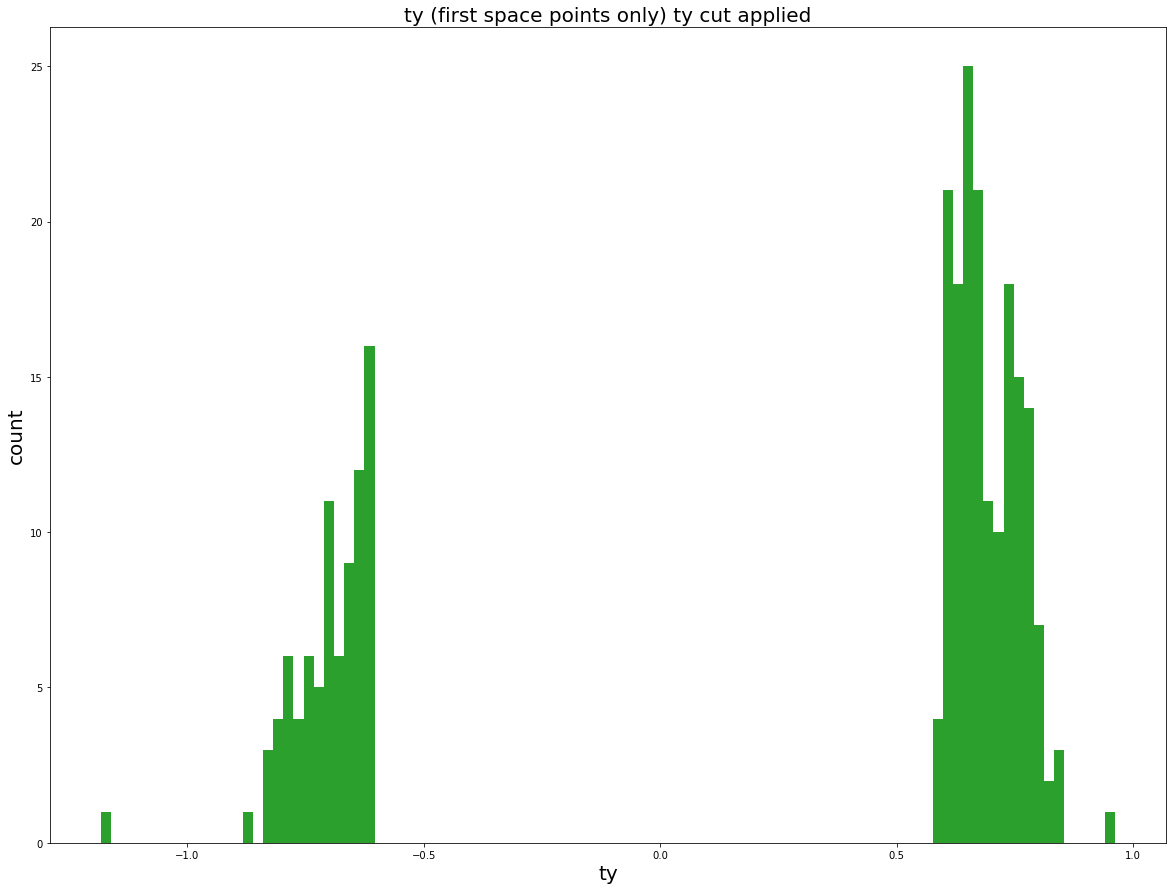

In [45]:
fig = plt.figure(figsize=(20,15))

plt.hist(ift_tyCut_L1['ty'], bins=100)
plt.title("ty (first space points only) ty cut applied", size=20)
plt.xlabel("ty",size=20)
plt.ylabel("count",size=20)
plt.show()

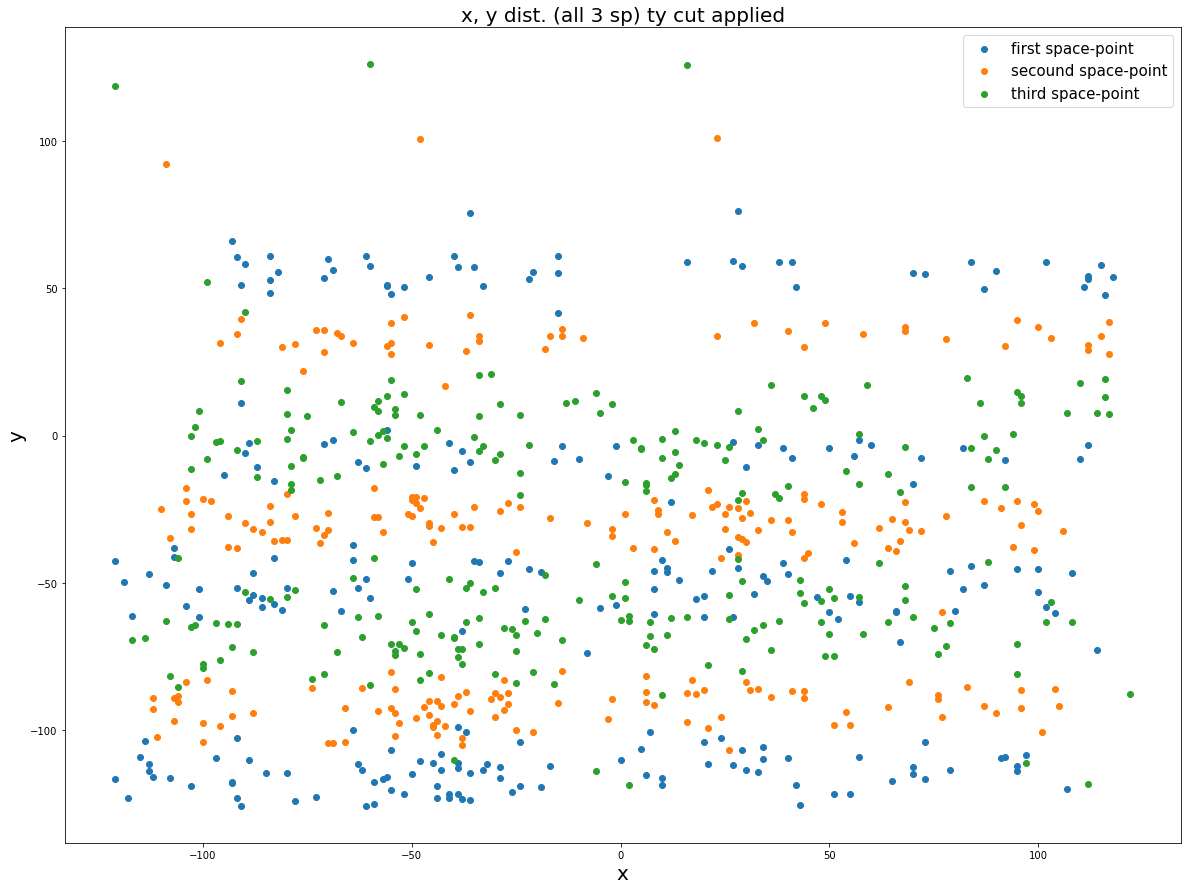

In [48]:
fig = plt.figure(figsize=(20,15))

plt.scatter(ift_tyCut_L1['x'],ift_tyCut_L1['y'], label="first space-point")
plt.scatter(ift_tyCut_L2['x'],ift_tyCut_L2['y'], label="secound space-point")
plt.scatter(ift_tyCut_L3['x'],ift_tyCut_L3['y'], label="third space-point")
plt.title("x, y dist. (all 3 sp) ty cut applied", size=20)
plt.xlabel("x",size=20)
plt.ylabel("y",size=20)
plt.legend(fontsize=15)
plt.show()

### Vector Field Function

In [90]:
include_tx = False
vector_width, vector_scale = 0.0023, 10
def vector_plot(data, name, cut, color1, color2, include_tx=include_tx, unit='mm'):  
    #plt.scatter(data['x'], data['y'], marker='.', alpha=0.7, label=f'{name}')
    pos = data[data['ty']>0]
    neg = data[data['ty']<0]
    if include_tx:
        plt.quiver(pos['x'], pos['y'], pos['tx'], pos['ty'], color=color1, alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty > 0')
        plt.quiver(neg['x'], neg['y'], neg['tx'], neg['ty'], color=color2, alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty < 0')
        #plt.quiver(data['x'], data['y'], data['tx'], data['ty'], color=color, alpha=0.7, width=vector_width, scale=vector_scale)
    else:
        plt.quiver(pos['x'], pos['y'], 0, pos['ty'], color=color1, alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty > 0')
        plt.quiver(neg['x'], neg['y'], 0, neg['ty'], color=color2, alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty < 0')
        #plt.quiver(data['x'], data['y'], 0, data['ty'], color=color, alpha=0.7, width=0.003, scale=14)
    plt.xlabel(f'x ({unit})', fontsize=15)
    plt.ylabel(f'y ({unit})', fontsize=15)
    plt.title(f'{name} ({cut[1]}> |ty| > {cut[0]})', fontsize=20)

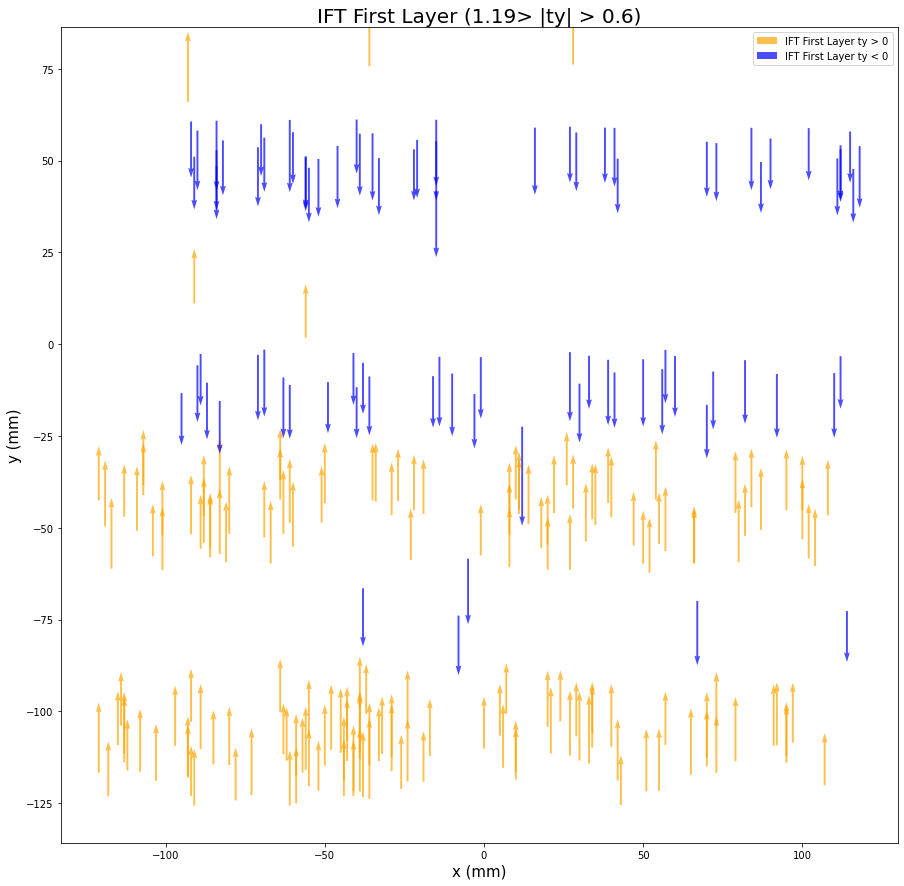

In [92]:
plt.figure(figsize=(15, 15))  
vector_plot(ift_tyCut_L1, 'IFT First Layer', [0.6, 1.19], color1='orange', color2='blue')

plt.legend()
plt.show()

## Extrapolation

In [111]:
gap = 31.5  # mm
def simple_projection(data):
    x_new = (gap)*np.array(data['tx']) + data['x']
    y_new = (gap)*np.array(data['ty']) + data['y']
    
    dict = {'x': x_new, 'y': y_new, 'tx': np.array(data['tx']), 'ty': np.array(data['ty'])}
    
    return pd.DataFrame(dict)

    

In [112]:
ift1_to_ift2 = simple_projection(ift_tyCut_L1)

In [113]:
type(ift1_to_ift2)

pandas.core.frame.DataFrame

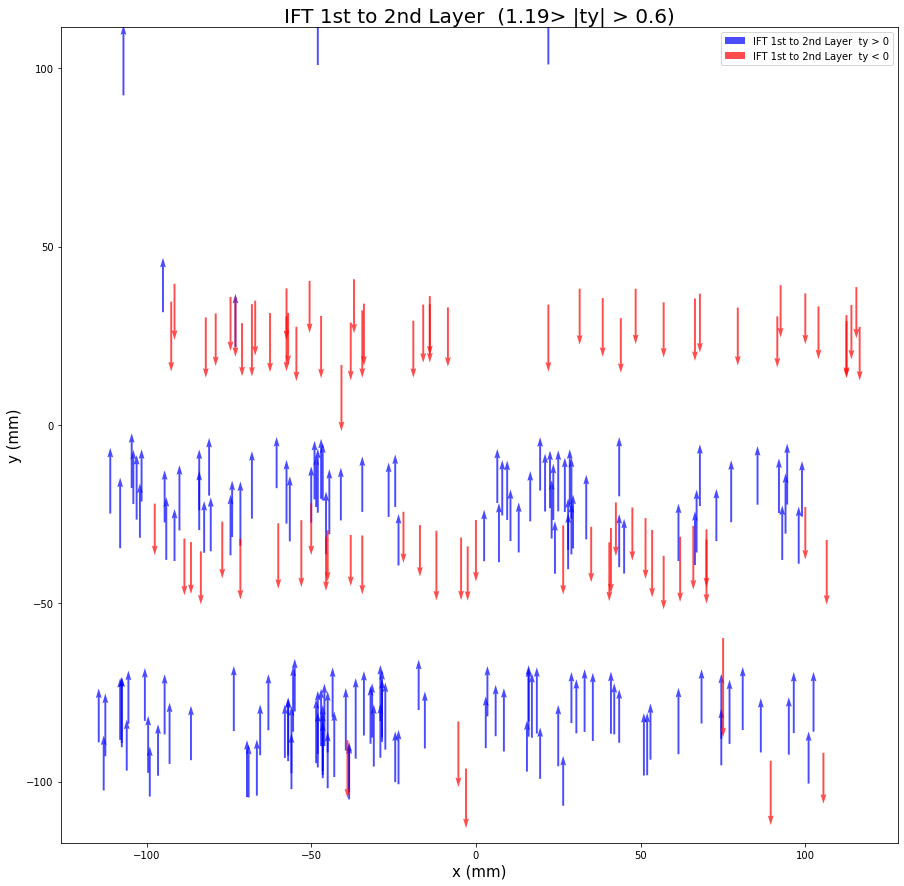

In [114]:
plt.figure(figsize=(15, 15))  
vector_plot(ift1_to_ift2, 'IFT 1st to 2nd Layer ', [0.6, 1.19], color1='blue', color2='red')
#vector_plot(ift_tyCut_L2, 'IFT 2nd Layer', [0.6, 1.19], color1='green', color2='m')

plt.legend()
plt.show()

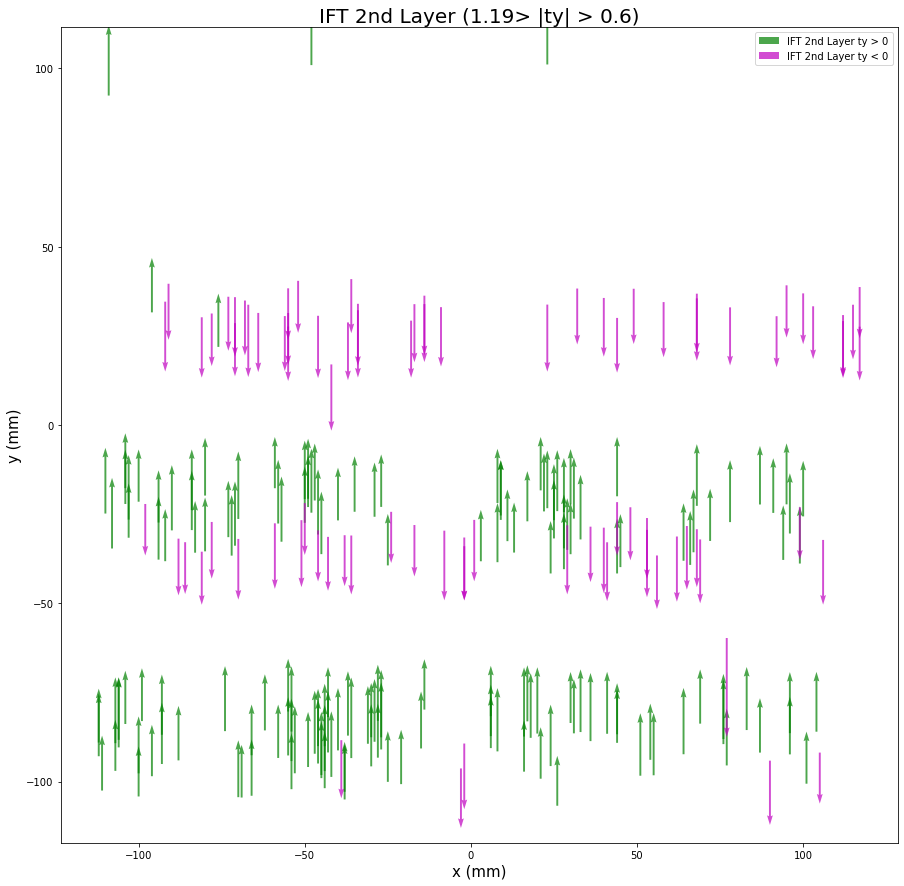

In [115]:
plt.figure(figsize=(15, 15))  
#vector_plot(ift1_to_ift2, 'IFT 1st to 2nd Layer ', [0.6, 1.19], color1='blue', color2='red')
vector_plot(ift_tyCut_L2, 'IFT 2nd Layer', [0.6, 1.19], color1='green', color2='m')

plt.legend()
plt.show()